In [1]:
using PyPlot,JLD2,CALCEPH

Using $\sqrt{e} \cos{\omega}$ and $\sqrt{e} \sin{\omega}$ as priors, doesnt work properly. don't know why. Reverted to previous prior $e \cos{\omega}$ and $e \sin{\omega}$

In [187]:
calc_deg(value) = value * 180/pi
calc_rad(value) = value * pi/180
function extract_data(filename)
	f = jldopen(String(filename), "r")
	return f["pbest_global"]
end
function evec(ecc,om)
    omega = calc_rad(om)
    ecosw = ecc*cos(omega)
    esinw = ecc*sin(omega)
    return ecosw,esinw
end

evec (generic function with 1 method)

## Posterior Distributions

In [202]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = extract_data("OUTPUTS/moon_fittry1params.jld2")

18-element Array{Float64,1}:
    2.5275788989834023e-6
  224.70077098675895     
    2.433503768851615e6  
    0.00285673419852034  
    0.0007550609482464021
    3.04375001408466e-6  
  365.25646214139175     
    2.433624407402546e6  
    0.015037015083073492 
    0.0029763518560029555
    0.000941720902889919 
 4309.232984673987       
    2.443388213396815e6  
    0.02441377873531106  
   -0.03777031122605469  
    9.295524225689489e-5 
   -0.0016399728262300934
    2.312317961379825    

In [203]:
@load("NYR40/moon_try1mcmc.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

In [11]:
include("decompose_ttvs.jl")
include("plot_ttvs.jl")
include("plot_likelihood.jl")
include("corner_plot.jl")

corner_planet (generic function with 1 method)

In [193]:
evec(0.00677323,131.53298)

(-0.004490997226230397, 0.005070265135758768)

Simulated with σ= 30 seconds


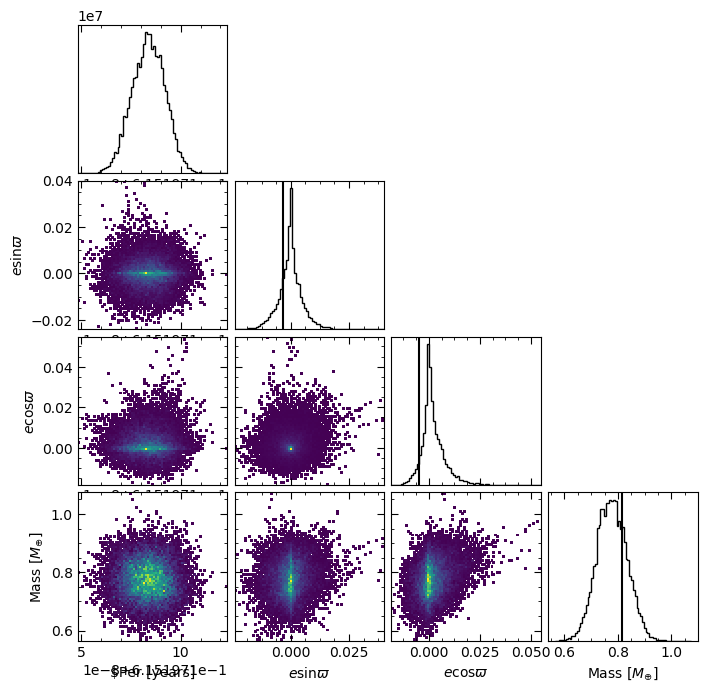

P-off-224.08550274004108
-0.004975858997178902<-ecos & esin->-0.003352734293109698


In [78]:
include("corner_plot.jl")
corner_planet(mcmc,30,75,"venus")

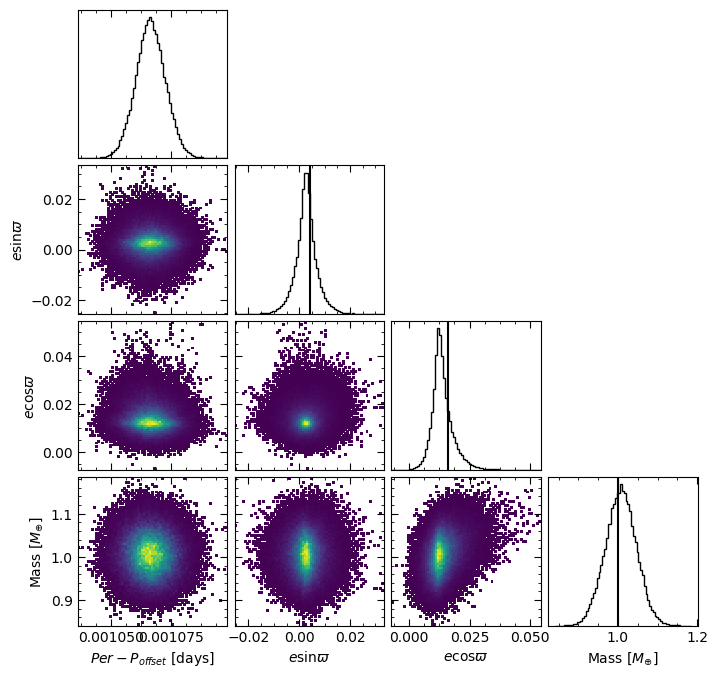

Simulated with σ= 30 seconds
P-offset0.0009999999999763531
0.016107124052845066<-ecos & esin->0.004410278307120753


In [76]:
corner_planet(mcmc,30,75,"earth")

Simulated with σ= 30 seconds


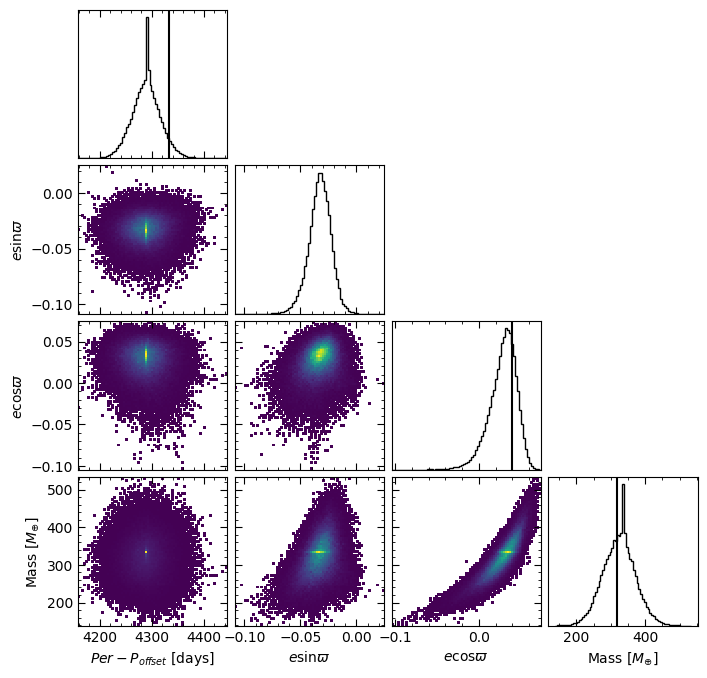

P-offset4332.82012875
0.04010139295881334<-ecos & esin->0.026379504975697257


In [77]:
corner_planet(mcmc,30,75,"jup")

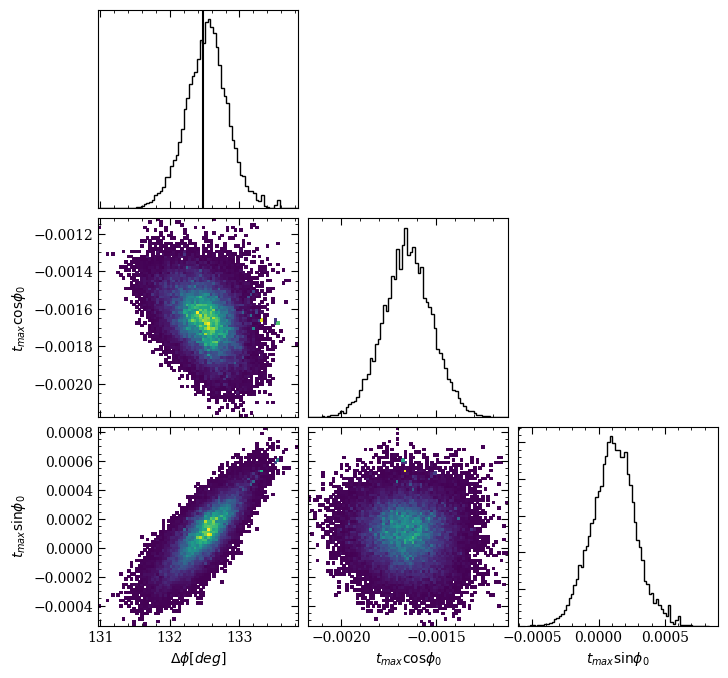

In [174]:
corner_moon(vec(par_mcmc[:,iburn:nsteps,16]),
    vec(par_mcmc[:,iburn:nsteps,17]),
    vec(par_mcmc[:,iburn:nsteps,18]).*57.2957795,75,
 0.00001,0.00001,2.3122.*57.2957795,"moon")

Using original prior on eccentricity.

In [183]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = extract_data("OUTPUTS/moon_fitmtry3params.jld2")
@load("mcmc_mtry3results.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

## Likelihoods And Probabilities

In [2]:
f = jldopen("FITS/p3_fit30.0s40.0yrs.jld2","r")
g = jldopen("FITS/moon_fit30.0s40.0yrs.jld2","r")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/FITS/moon_fit30.0s40.0yrs.jld2 (read-only)
 ├─🔢 pbest_p3
 ├─🔢 pbest_dp
 ├─🔢 lprob_p3
 ├─🔢 lprob_dp
 ├─🔢 lprob_best
 ├─🔢 pbest_global
 ├─🔢 ntrans
 ├─🔢 nplanet
 ├─🔢 tt0
 ├─🔢 tt
 ├─🔢 ttmodel
 ├─🔢 sigtt
 ├─🔢 p3in
 ├─🔢 p3out
 ├─🔢 np3
 ├─🔢 nphase
 ├─🔢 dpin
 ├─🔢 dpout
 └─🔢 ndp

In [26]:
mcmc = jldopen("MCMC/p3_mcmc30.0s40.0yrs.jld2")
moon = jldopen("MCMC/moon_mcmc30.0s40.0yrs.jld2")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/MCMC/moon_mcmc30.0s40.0yrs.jld2 (read-only)
 ├─🔢 par_mcmc
 ├─🔢 lprob_mcmc
 ├─🔢 param
 ├─🔢 nwalkers
 ├─🔢 nsteps
 ├─🔢 accept
 ├─🔢 iburn
 └─🔢 indepsamples

In [3]:
# f = jldopen("FITS/p3_fit30.0s40.0yrs.jld2","r")
wide = jldopen("FITS/p3_widefit30.0s40.0yrs.jld2","r")
grid_wide = (10 .^ range(log10(wide["p3in"]),stop=log10(wide["p3out"]),length=wide["np3"])) /365.25
lprob_wide = exp.((wide["lprob_p3"] .-maximum(f["lprob_p3"])))

xgrid = (10 .^ range(log10(f["p3in"]),stop=log10(f["p3out"]),length=f["np3"])) /365.25
xprob = exp.((f["lprob_p3"] .-maximum(f["lprob_p3"])))


100-element Array{Float64,1}:
 2.0565136362713246e-5 
 3.0338010875769516e-5 
 4.45395037921047e-5   
 6.506327101592419e-5  
 9.455719138740711e-5  
 0.00013669670632574413
 0.00019654114919993724
 0.00028100987951051155
 0.00039947479360921006
 0.0005645385453117475 
 0.0007929921051064429 
 0.001107007575204465  
 0.0015355706983556292 
 ⋮                     
 0.0011731437990394437 
 0.0008431833596150389 
 0.0006023714296079696 
 0.0004278071372535105 
 0.0003020952817830991 
 0.00021213701232188884
 0.0001481639747368943 
 0.00010294012384364075
 7.115643647834202e-5  
 4.894427991790503e-5  
 3.350549161632392e-5  
 2.2831186845949376e-5 

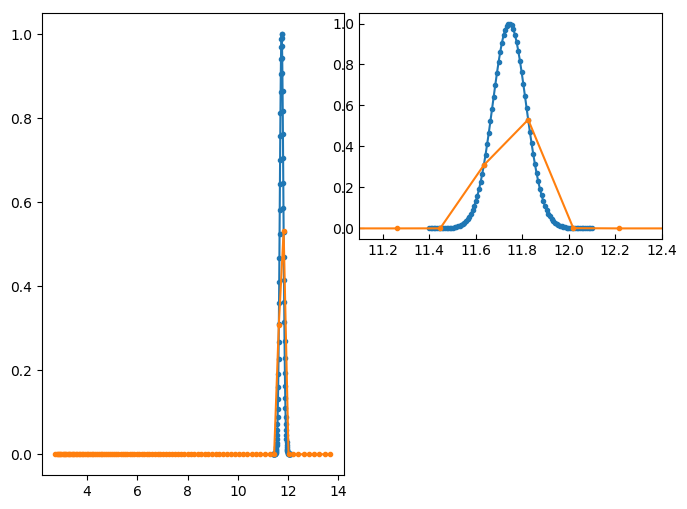

In [4]:
M = [xgrid xprob ;grid_wide lprob_wide]
sorted = sortperm(M[:,1])
fig = plt.figure(figsize=(8,6))
subplots_adjust(hspace=0.05,wspace=0.05)
ax1=fig.add_subplot(121)
# plot(M[:,1][sorted],M[:,2][sorted],".",linestyle="-")
plot(xgrid,xprob,".",linestyle="-")
plot(grid_wide, lprob_wide,".",linestyle="-")
# ax1.tick_params(direction="in",left=false,labelleft=false,right=true,labelright=true)
ax2=fig.add_subplot(222)
# plot(M[:,1][sorted],M[:,2][sorted],".",linestyle="-")
plot(xgrid,xprob,".",linestyle="-")
plot(grid_wide, lprob_wide,".",linestyle="-")
xlim(11.1,12.4)
ax2.tick_params(direction="in")

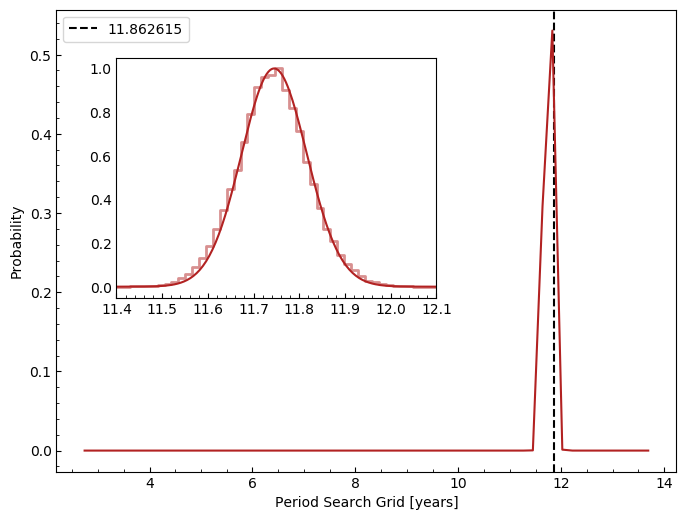

100


In [35]:
include("plot_likelihood.jl")
plot_likelihood(f,mcmc,false)

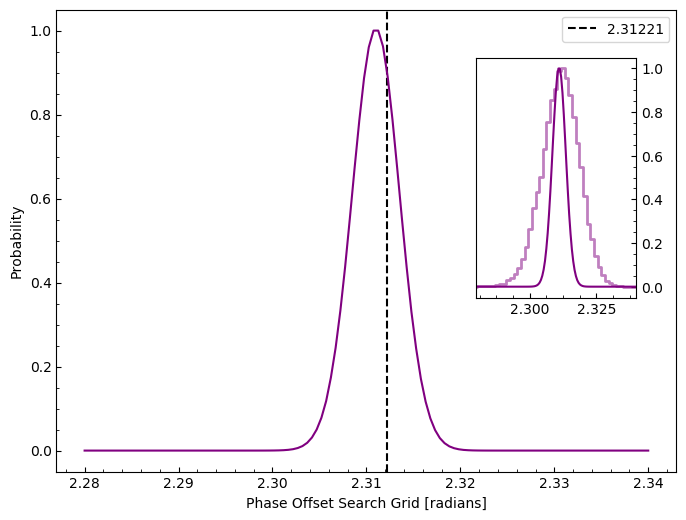

In [37]:
include("plot_likelihood.jl")
plot_likelihood(g,moon,true)

jupiter period agreement --> unique solution & not degenerate

In [44]:
using Distributions,Optim

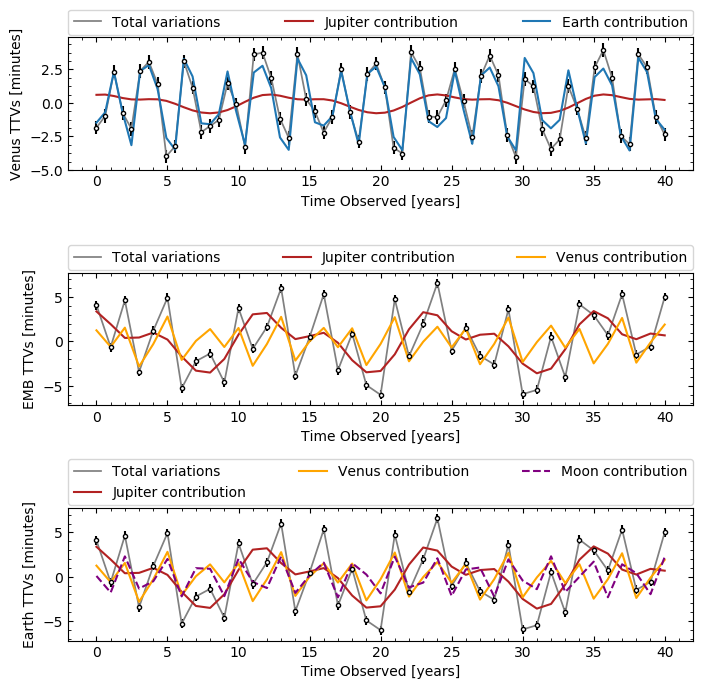

Simulated with σ= 30 seconds


In [44]:
include("plot_ttvs.jl")
plot_ttvs(g,30,true)
# savefig("IMAGES/EMBttvs.eps")

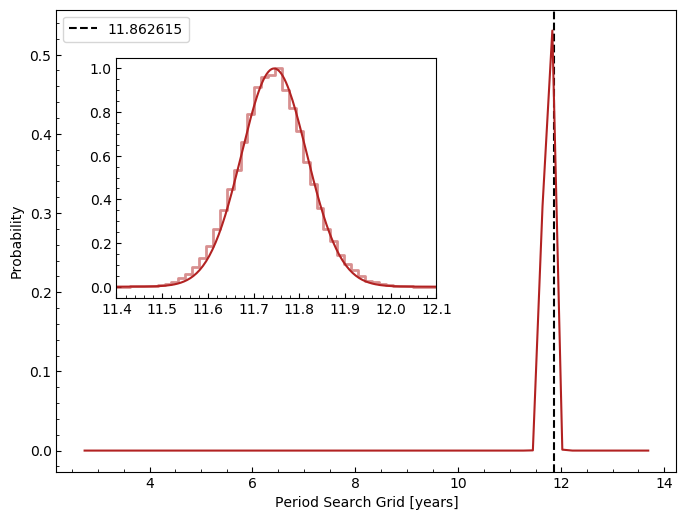

In [45]:
include("plot_likelihood.jl")
plot_likelihood(f,mcmc,false)

include("plot_orbits.jl")
plot_orbits(3,false)

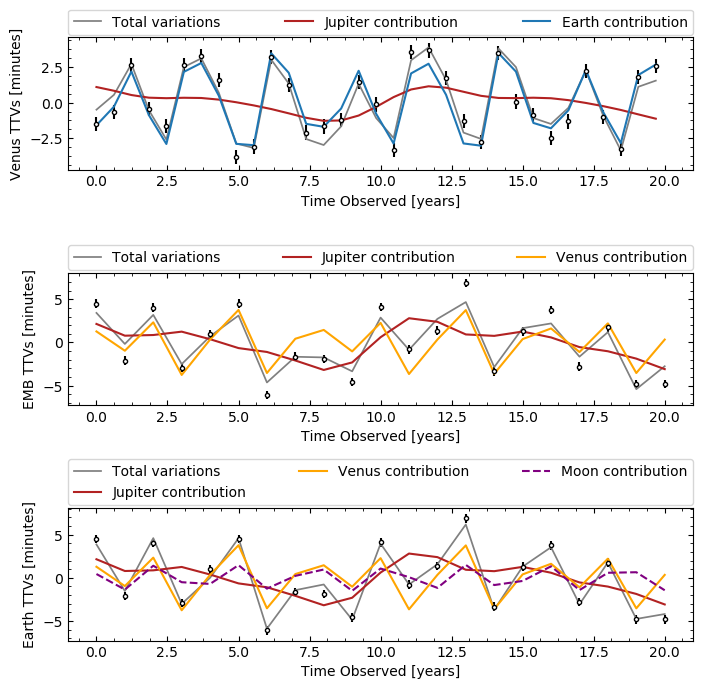

Simulated with σ= 30 seconds


In [59]:
f3 = jldopen("FITS/p3_fit30.0s20.0yrs.jld2","r")
g3 = jldopen("FITS/moon_fit30.0s20.0yrs.jld2","r")
plot_ttvs(g3,30,true)

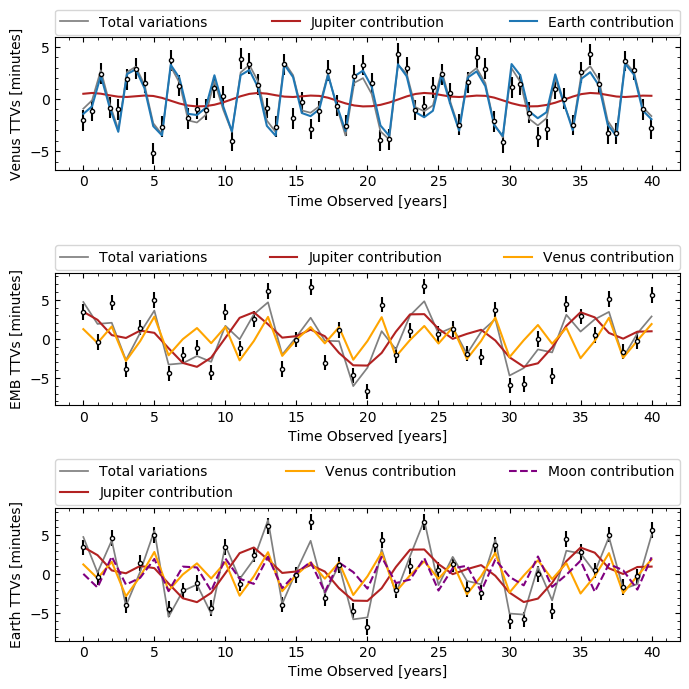

Simulated with σ= 60 seconds


In [58]:
include("plot_ttvs.jl")
f6 = jldopen("FITS/p3_fit60.0s40.0yrs.jld2","r")
g6 = jldopen("FITS/moon_fit60.0s40.0yrs.jld2","r")
plot_ttvs(g6,60,true)

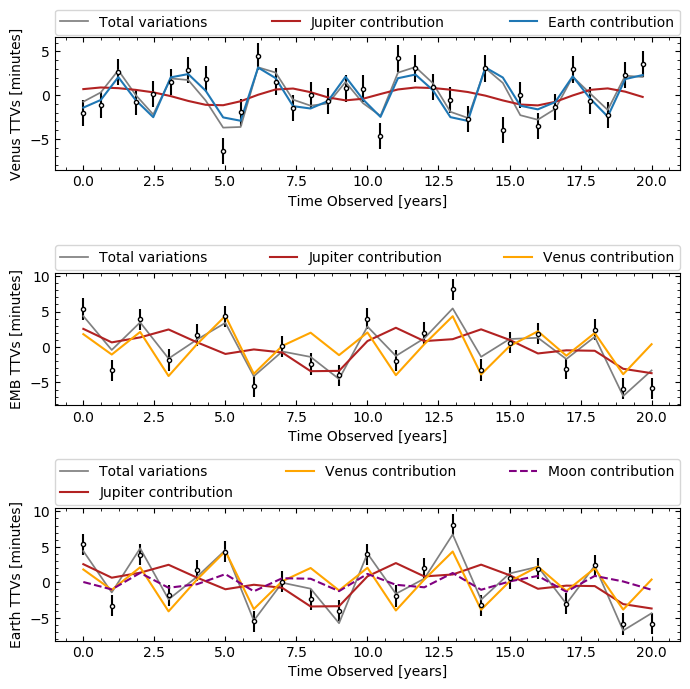

Simulated with σ= 90 seconds


In [60]:
f9 = jldopen("FITS/p3_fit90.0s20.0yrs.jld2","r")
g9 = jldopen("FITS/moon_fit90.0s20.0yrs.jld2","r")
plot_ttvs(g9,90,true)